In [19]:
import os
import numpy as np
import librosa
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from keras.regularizers import l2

warnings.filterwarnings('ignore')

In [8]:
!pip install resampy

!pip install --upgrade librosa

In [9]:
# Label mapping functions remain unchanged
def tess_label(filename):
    label = filename.split('_')[-1].split('.')[0].lower()
    return label if label not in ['ps', 'calm'] else None

def ravdess_label(filename):
    label = filename.split('-')[2]
    emotion_map = {
        '01': 'neutral', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fear', '07': 'disgust'
    }
    return emotion_map.get(label, None)

def crema_label(filename):
    label = filename.split('_')[-2].lower()
    emotion_map = {
        'neu': 'neutral', 'hap': 'happy', 'sad': 'sad',
        'ang': 'angry', 'fea': 'fear', 'disgust': 'disgust'
    }
    return emotion_map.get(label, None)

def savee_label(filename):
    label1 = filename[0]
    label2 = filename[:2]
    if label1 == 'a': return 'angry'
    elif label1 == 'd': return 'disgust'
    elif label1 == 'h': return 'happy'
    elif label1 == 'f': return 'fear'
    elif label1 == 'n': return 'neutral'
    elif label2 == 'sa': return 'sad'
    return None

In [10]:
def extract_features(file_path, max_len=40, target_sr=44100):
    try:
        audio, original_sr = librosa.load(file_path, sr=None)
        if original_sr != target_sr:
            audio = librosa.resample(y=audio, orig_sr=original_sr, target_sr=target_sr)
        
        # Trim silence and normalize duration
        audio, _ = librosa.effects.trim(audio, top_db=30)
        target_length = 3 * target_sr
        if len(audio) > target_length:
            audio = audio[:target_length]
        else:
            audio = np.pad(audio, (0, max(0, target_length - len(audio))))

        # Extract features ensuring proper dimensions
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=20).T, axis=0)
        mel_spec = np.mean(librosa.feature.melspectrogram(y=audio, sr=target_sr).T, axis=0)[:20]
        spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=audio, sr=target_sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=target_sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=target_sr))
        
        # Rhythm and tempo
        tempo, _ = librosa.beat.beat_track(y=audio, sr=target_sr)
        tempo = np.array([tempo])  # Convert to array
        
        # RMS energy
        rmse = np.mean(librosa.feature.rms(y=audio))
        
        # Chroma features
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=target_sr).T, axis=0)
        
        # Zero crossing rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio))
        
        # Combine all features
        feature_list = [
            mfccs,
            mel_spec,
            np.array([spectral_centroids]),
            np.array([spectral_rolloff]),
            np.array([spectral_bandwidth]),
            np.array([tempo]),
            np.array([rmse]),
            chroma,
            np.array([zcr])
        ]
        
        # Concatenate and pad
        features = np.concatenate([f.flatten() for f in feature_list])
        if len(features) < max_len:
            features = np.pad(features, (0, max_len - len(features)))
        return features
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [11]:
def load_dataset_with_features(directory, label_map, feature_save_path="features.pkl", max_files=None, target_sr=44100):
    if os.path.exists(feature_save_path):
        with open(feature_save_path, 'rb') as file:
            data = pickle.load(file)
        return data['features'], data['labels']

    features, labels = [], []
    count = 0
    
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(('.wav', '.WAV')):
                file_path = os.path.join(dirname, filename)
                label = label_map(filename)
                if label:
                    feature = extract_features(file_path, target_sr=target_sr)
                    if feature is not None:
                        features.append(feature)
                        labels.append(label)
                        count += 1
                        if max_files and count >= max_files:
                            break

    # Save features
    if features and labels:
        with open(feature_save_path, 'wb') as file:
            pickle.dump({'features': features, 'labels': labels}, file)

    return np.array(features), np.array(labels)

In [12]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse_output=False)
    onehot_encoded = onehot_encoder.fit_transform(encoded.reshape(-1, 1))
    return onehot_encoded, label_encoder

In [13]:
target_sr = 44100
features_tess, labels_tess = load_dataset_with_features('/kaggle/input/tess-dataset', tess_label, "tess.pkl", target_sr=target_sr)
features_ravdess, labels_ravdess = load_dataset_with_features('/kaggle/input/ravdess', ravdess_label, "ravdess.pkl", target_sr=target_sr)
features_crema, labels_crema = load_dataset_with_features('/kaggle/input/crema-dataset', crema_label, "crema.pkl", target_sr=target_sr)
features_savee, labels_savee = load_dataset_with_features('/kaggle/input/savee-dataset', savee_label, "savee.pkl", target_sr=target_sr)

# Combine datasets
features = np.vstack((features_tess, features_ravdess, features_crema, features_savee))
labels = np.hstack((labels_tess, labels_ravdess, labels_crema, labels_savee))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Save scaler for inference
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Encode labels
labels_onehot, label_encoder = encode_labels(labels)

# Save label encoder for inference
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    features_scaled, labels_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=labels_onehot
)
np.unique(labels,return_counts=True)


(array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'], dtype='<U7'),
 array([2310, 1052, 2323, 2323, 2103, 2323]))

In [15]:
def build_improved_ann(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),
        
        # First block with larger capacity
        Dense(2048, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Second block
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Third block
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Fourth block
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Use a custom learning rate schedule
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
def augment_data(X, y, noise_factor=0.05, shift_max=5, scale_factor=0.1):
    """
    Augment the data with multiple techniques including adding noise, shifting, and scaling.
    
    Parameters:
        X (np.ndarray): Input feature array of shape (n_samples, n_features).
        y (np.ndarray): Target labels array of shape (n_samples, n_classes).
        noise_factor (float): Standard deviation of noise to add.
        shift_max (int): Maximum number of positions to shift.
        scale_factor (float): Range for scaling factor (±scale_factor).
        
    Returns:
        X_augmented (np.ndarray): Augmented feature array.
        y_augmented (np.ndarray): Corresponding augmented labels.
    """
    X_augmented = []
    y_augmented = []
    
    for i in range(len(X)):
        # Add original sample
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        
        # Add noisy version
        noise = np.random.normal(0, noise_factor, X[i].shape)
        X_augmented.append(X[i] + noise)
        y_augmented.append(y[i])
        
        # Shift features
        shift = np.random.randint(-shift_max, shift_max)
        X_shifted = np.roll(X[i], shift)
        X_augmented.append(X_shifted)
        y_augmented.append(y[i])
        
        # Scale features
        scale = 1 + np.random.uniform(-scale_factor, scale_factor)
        X_scaled = X[i] * scale
        X_augmented.append(X_scaled)
        y_augmented.append(y[i])
        
        # Add random inversion
        if np.random.rand() > 0.5:
            X_inverted = -X[i]
            X_augmented.append(X_inverted)
            y_augmented.append(y[i])
        
    return np.array(X_augmented), np.array(y_augmented)

In [17]:
def train_improved_model(X_train, y_train, X_val, y_val):
    # Augment training data
    X_train_aug, y_train_aug = augment_data(X_train, y_train)
    
    # Build model
    model = build_improved_ann(input_shape=X_train.shape[1], num_classes=y_train.shape[1])
    
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_aug,
        y_train_aug,
        epochs=150,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [20]:
model, history = train_improved_model(X_train, y_train, X_val, y_val)

Epoch 1/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4667 - loss: 13.9627 - val_accuracy: 0.6265 - val_loss: 1.9722 - learning_rate: 0.0010
Epoch 2/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5393 - loss: 2.0721 - val_accuracy: 0.6317 - val_loss: 1.7341 - learning_rate: 0.0010
Epoch 3/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5567 - loss: 1.9552 - val_accuracy: 0.6582 - val_loss: 1.7707 - learning_rate: 0.0010
Epoch 4/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5559 - loss: 1.9513 - val_accuracy: 0.6429 - val_loss: 1.7188 - learning_rate: 0.0010
Epoch 5/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5642 - loss: 1.9236 - val_accuracy: 0.6224 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 6/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5693 - loss: 1.8843 - val_accuracy: 0.6446 - val_loss: 1.6560 - learning_rate: 0.0010
Epoch 7/150
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5733 - loss:

In [25]:
def plot_training_curves(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    
    plt.tight_layout()
    plt.show()

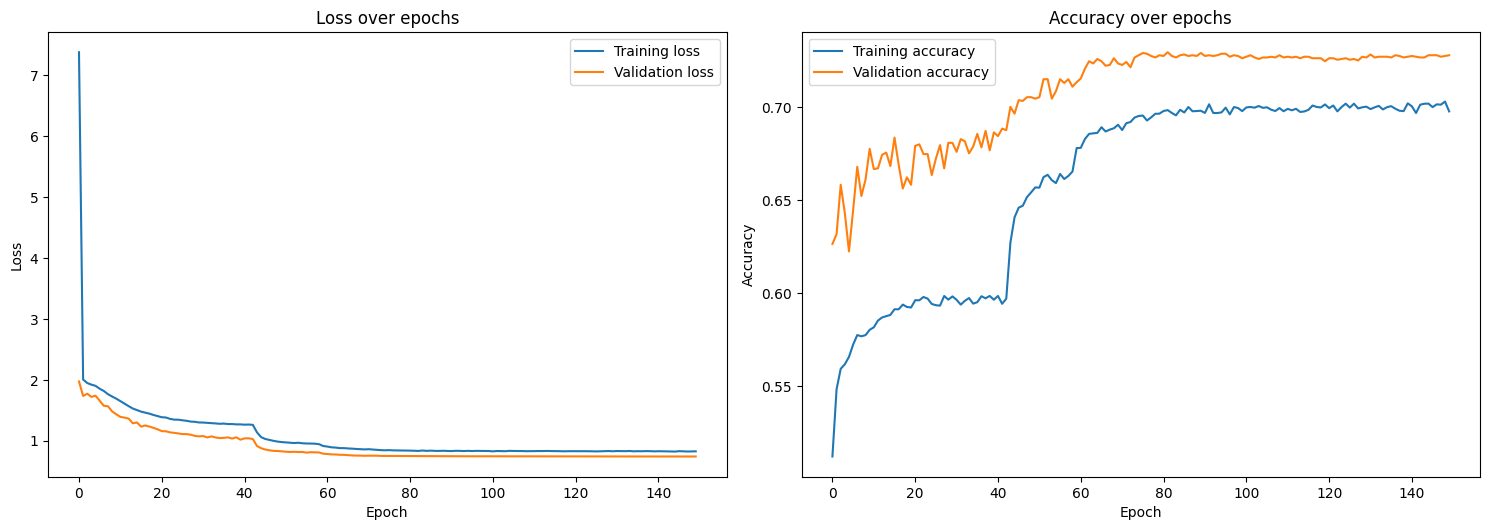


Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.79      0.81       462
     disgust       0.93      0.90      0.91       210
        fear       0.68      0.60      0.64       465
       happy       0.67      0.62      0.65       465
     neutral       0.64      0.81      0.72       420
         sad       0.74      0.74      0.74       465

    accuracy                           0.73      2487
   macro avg       0.75      0.74      0.74      2487
weighted avg       0.73      0.73      0.73      2487



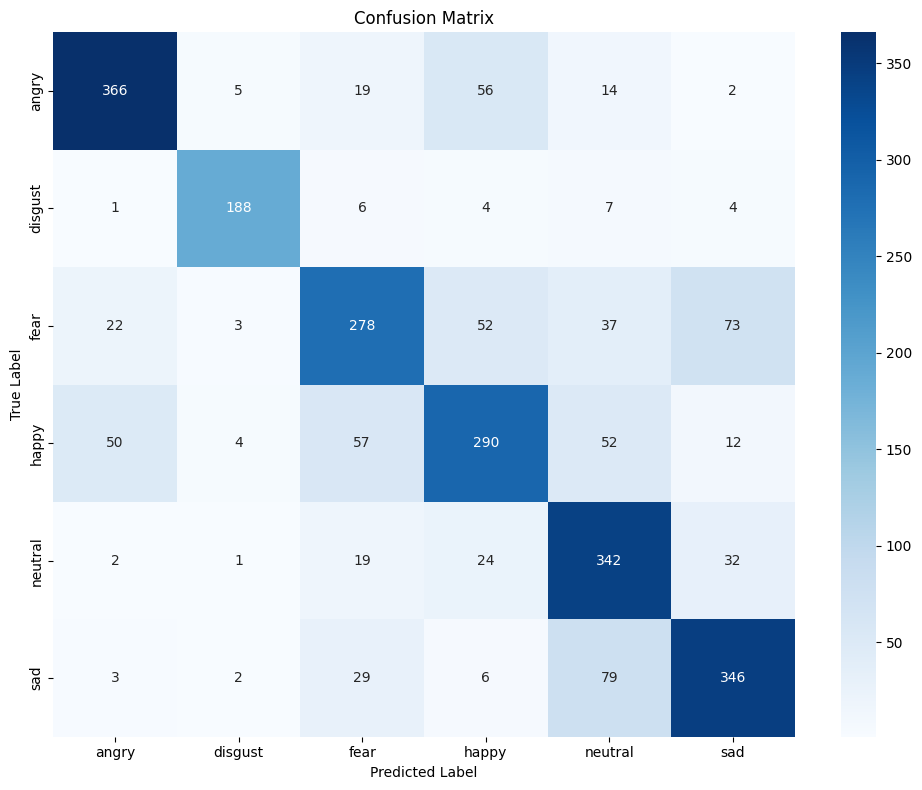

In [26]:
plot_training_curves(history)

# Evaluate model
y_val_pred = model.predict(X_val, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=label_encoder.classes_))
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save final model and artifacts
model.save('final_model.h5')